In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [7]:
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified


In [8]:
# Create a dictionary to store the indices of each class
indices = {}
for i in range(10):
    indices[i] = []

# Find the indices of each class in the training dataset
for idx, (data, label) in enumerate(train_dataset):
    indices[label].append(idx)

# Create a new list of indices containing only 500 images per class
new_indices = []
for i in range(10):
    new_indices += indices[i][:500]

# Create a new sampler that uses the new list of indices
sampler = torch.utils.data.sampler.SubsetRandomSampler(new_indices)

In [9]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          sampler=sampler, num_workers=2)

In [10]:
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
import torch.nn as nn

In [12]:
# import torch
# import torchvision.models as models

# # Download the ResNet-18 model
# resnet18 = models.resnet18(pretrained=True)

# # Print the model architecture
# print(resnet18)

In [13]:
def accuracy_fn(true,pred):
  correct=torch.eq(true,pred).sum().item()
  
  acc=correct/(len(pred))*100
  #print(acc)
  return acc


In [14]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Linear(512, num_classes)  # change last layer for CIFAR-10
        #0.2 0.2 0.2 0.2
        #0.5 0.2 0.1 0.3
        # Add dropout layers
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.dropout1(x)  # add dropout after layer1

        x = self.resnet18.layer2(x)
        x = self.dropout2(x)  # add dropout after layer2

        x = self.resnet18.layer3(x)
        x = self.dropout3(x) #add dropout after layer3
        x = self.resnet18.layer4(x)
        x = self.dropout4(x) #add dropout after layer4
        x = self.resnet18.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet18.fc(x)

        return x

modeltiny = ResNet18()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# class ResNet18(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet18, self).__init__()
#         self.resnet18 = torchvision.models.resnet18(pretrained=False)
#         self.resnet18.fc = nn.Linear(512, num_classes)  # change last layer for CIFAR-10
        
#         # Add dropout layers
#         self.dropout1 = nn.Dropout(p=0.2)
#         self.dropout2 = nn.Dropout(p=0.2)
        
#     def forward(self, x):
#         x = self.resnet18.conv1(x)
#         x = self.resnet18.bn1(x)
#         x = self.resnet18.relu(x)
#         x = self.resnet18.maxpool(x)

#         x = self.resnet18.layer1(x)
#         x = self.dropout1(x)  # add dropout after layer1

#         x = self.resnet18.layer2(x)
#         x = self.dropout2(x)  # add dropout after layer2

#         x = self.resnet18.layer3(x)
#         x = self.resnet18.layer4(x)
#         x = self.resnet18.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.resnet18.fc(x)

#         return x

# model = ResNet18()

In [17]:
model = modeltiny.to(device)

In [18]:
loss_fn=nn.CrossEntropyLoss()
#optimizer=torch.optim.Adam(params=model.parameters(),lr=0.0001)

In [19]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [20]:
import  matplotlib.pyplot as  plt

In [21]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(true=y,
                                 pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_acc


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn
              ):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(true=y,pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_acc

In [22]:
from numpy import testing
torch.manual_seed(42)
epochs=120
from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_model_1=timer()
test_acc=0
epochlist=[]
trainacc=[]
testacc=[]
for epoch in tqdm(range(epochs)):
  print(f"epochs{epoch}")
  train=train_step(data_loader=trainloader,
             model=model,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  trainacc.append(train)
  test=test_step(data_loader=testloader,
             model=model,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn)
  testacc.append(test)

  0%|          | 0/120 [00:00<?, ?it/s]

epochs0
Train loss: 2.53951 | Train accuracy: 13.47%
Test loss: 2.25359 | Test accuracy: 17.78%

epochs1
Train loss: 2.11516 | Train accuracy: 21.68%
Test loss: 1.92578 | Test accuracy: 26.70%

epochs2
Train loss: 1.98989 | Train accuracy: 25.04%
Test loss: 1.93698 | Test accuracy: 25.17%

epochs3
Train loss: 1.89200 | Train accuracy: 28.94%
Test loss: 1.77762 | Test accuracy: 31.79%

epochs4
Train loss: 1.81456 | Train accuracy: 32.10%
Test loss: 1.70815 | Test accuracy: 37.75%

epochs5
Train loss: 1.80202 | Train accuracy: 33.25%
Test loss: 1.75848 | Test accuracy: 36.01%

epochs6
Train loss: 1.74777 | Train accuracy: 35.44%
Test loss: 1.70420 | Test accuracy: 39.06%

epochs7
Train loss: 1.67675 | Train accuracy: 38.27%
Test loss: 1.67718 | Test accuracy: 38.34%

epochs8
Train loss: 1.65894 | Train accuracy: 39.14%
Test loss: 1.63574 | Test accuracy: 40.10%

epochs9
Train loss: 1.64405 | Train accuracy: 39.56%
Test loss: 1.57303 | Test accuracy: 42.21%

epochs10
Train loss: 1.62498 |

In [23]:
print(trainacc
      )

[13.469145569620252, 21.67721518987342, 25.039556962025316, 28.935917721518987, 32.100474683544306, 33.24762658227848, 35.44303797468354, 38.27136075949367, 39.14161392405063, 39.55696202531646, 39.87341772151899, 40.72389240506329, 42.464398734177216, 42.62262658227848, 42.91930379746835, 42.95886075949367, 44.75870253164557, 44.89715189873418, 46.99367088607595, 47.21123417721519, 49.36708860759494, 48.87262658227848, 47.46835443037975, 50.534018987341774, 50.039556962025316, 51.38449367088607, 51.89873417721519, 52.017405063291136, 53.95569620253165, 53.93591772151899, 54.27215189873418, 54.549050632911396, 55.874208860759495, 55.89398734177215, 55.735759493670884, 57.772943037974684, 58.54430379746835, 58.761867088607595, 58.0498417721519, 58.22784810126582, 59.53322784810127, 60.10680379746835, 60.14636075949367, 62.18354430379747, 62.24287974683544, 62.59889240506329, 63.72626582278481, 62.67800632911393, 64.5371835443038, 64.14161392405063, 63.924050632911396, 65.07120253164557,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


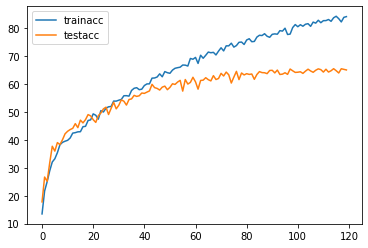

In [24]:
epochlist=[]
for i in range(120):
  epochlist.append(i)
print(epochlist)
# importing package
import matplotlib.pyplot as plt
# plot lines
plt.plot(epochlist,trainacc, label = "trainacc")
plt.plot(epochlist,testacc, label = "testacc")
plt.legend()
plt.show()